In [17]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../") # go to parent dir

import numpy as np
import scipy
import torch
import matplotlib.pyplot as plt
import mpmath
import networkx as nx

from metal.label_model import LabelModel, LabelModelInd
from metal.label_model.graph_utils import JunctionTree
from synthetic.generate_spa import (
    ChainDependencies,
    TreeDependencies,
    ClusterDependencies,
    DataGenerator
)
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


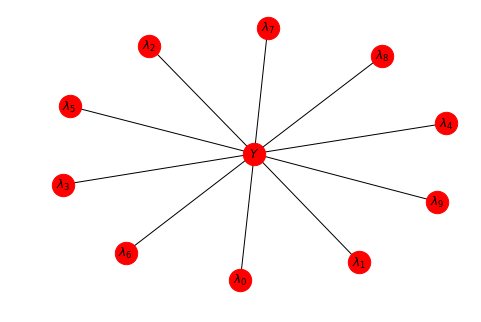

In [2]:
M = 10
N_CLUSTERS = 10
EDGE_PROB = 0.0
deps_graph = ClusterDependencies(M, N_CLUSTERS, edge_prob=EDGE_PROB)
# deps_graph = ChainDependencies(M)
deps_graph.draw()

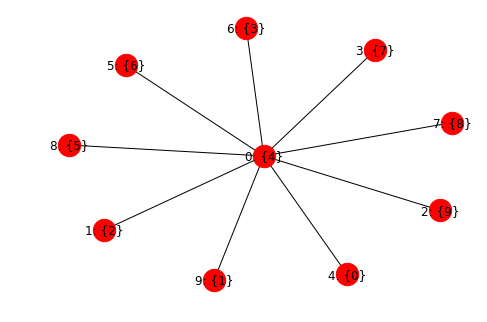

In [3]:
N = 1000 # Not used yet...
K = 3
HIGHER_ORDER_CLIQUES = True

data = DataGenerator(
    N,
    M,
    k=K,
    abstains=False,
    deps_graph=deps_graph,
    higher_order_cliques=HIGHER_ORDER_CLIQUES
)
data.jt.draw()

In [4]:
%time sigma_O = data.get_sigma_O()

CPU times: user 486 ms, sys: 3.11 ms, total: 489 ms
Wall time: 488 ms


In [5]:
np.linalg.cond(sigma_O)

7.120248804879142

In [6]:
E_O = np.array([data.P_marginal(v) for i, v in data.jt.iter_observed()])

In [7]:
class_balance = data.get_class_balance()
class_balance

array([0.07442578, 0.88708248, 0.03849174])

In [8]:
lm = LabelModel(k=3)

lm.train(
    sigma_O=sigma_O,
    E_O=E_O,
    junction_tree=data.jt,
    class_balance=class_balance,
    lr=0.001,
    n_epochs=10000,
    print_every=1000,
    l2=0
)

mu = data.get_mu()
np.mean(np.abs(mu - lm.mu))

Estimating Z...
[E:0]	Train Loss: 429.45394897
[E:1000]	Train Loss: 0.00000000
[E:2000]	Train Loss: 0.00000000
[E:3000]	Train Loss: 0.00000000
[E:4000]	Train Loss: 0.00000000
[E:5000]	Train Loss: 0.00000000
[E:6000]	Train Loss: 0.00000000
[E:7000]	Train Loss: 0.00000000
[E:8000]	Train Loss: 0.00000000
[E:9000]	Train Loss: 0.00000000
[E:9999]	Train Loss: 0.00000000
Finished Training


0.016592250783079604

In [9]:
C = np.diag([1,1])
sigma_OH_est = lm.get_sigma_OH(C)
sigma_OH = data.get_sigma_OH()

print(np.mean(np.abs(sigma_OH - sigma_OH_est)))

np.hstack([sigma_OH_est, sigma_OH])

0.0130817674439918


array([[-0.0107183 , -0.01434536,  0.03722522, -0.01124524],
       [-0.01453278,  0.01470207, -0.01583686,  0.01461772],
       [-0.01034257, -0.01005889,  0.02857419, -0.00754247],
       [-0.0131249 ,  0.00906902, -0.00613102,  0.00952125],
       [ 0.0009475 , -0.00737574,  0.01349198, -0.00656458],
       [-0.02030406,  0.00320332,  0.01153551,  0.00526211],
       [-0.0065704 , -0.01590866,  0.03663334, -0.01311503],
       [-0.00287105,  0.006421  , -0.00995623,  0.00596285],
       [-0.00908235, -0.01838854,  0.04364488, -0.01497917],
       [-0.00451386,  0.00549939, -0.00673031,  0.00535608],
       [-0.00286588, -0.0113702 ,  0.02458215, -0.00959535],
       [-0.01259244,  0.01456565, -0.01726874,  0.01426325],
       [-0.01150686, -0.01219198,  0.03373383, -0.00926663],
       [-0.0019669 ,  0.01116312, -0.01995404,  0.01000003],
       [-0.00018528, -0.01120034,  0.02190828, -0.00977172],
       [-0.00060361,  0.00973845, -0.01838009,  0.00858899],
       [-0.01254308, -0.

In [10]:
Z_est = lm.Z.detach().numpy()
Z_est

array([[ 0.46602732,  0.01941721],
       [ 0.2798593 , -0.44105965],
       [ 0.42627996,  0.02808731],
       [ 0.30998972, -0.22054894],
       [ 0.39205983,  0.08202481],
       [ 0.49029157, -0.06942825],
       [ 0.3622052 ,  0.22931702],
       [ 0.13557412, -0.04833345],
       [ 0.81561685,  0.4463555 ],
       [ 0.6091122 ,  0.22161302],
       [ 0.24132907,  0.0166413 ],
       [ 0.09370503, -0.3329964 ],
       [ 0.30857912,  0.06228388],
       [-0.03537071, -0.295609  ],
       [ 0.11042678,  0.11832114],
       [-0.10530253, -0.14793344],
       [ 0.5644078 , -0.05540634],
       [ 0.48549753, -0.33027652],
       [ 0.5944107 , -0.05032917],
       [ 0.5080961 , -0.19259328]], dtype=float32)

## Check all the basic steps...

### First, we check the estimate of $ZZ^T$

We have, from the definitions, that:
$$
ZZ^T = \Sigma_O^{-1} \Sigma_{OH} \left( \Sigma_H - \Sigma_{OH}^T\Sigma_O^{-1}\Sigma_{OH} \right)^{-1} \Sigma_{OH}^T\Sigma_O^{-1}
$$

In [11]:
# The true covariance matrices
sigma_O = data.get_sigma_O()
sigma_O_inv = np.linalg.inv(sigma_O)
sigma_OH = data.get_sigma_OH()
sigma_H = data.get_sigma_H()

In [13]:
ZZT = sigma_O_inv @ sigma_OH @ np.linalg.inv(sigma_H - sigma_OH.T @ sigma_O_inv @ sigma_OH) @ sigma_OH.T @ sigma_O_inv
ZZT_est = Z_est @ Z_est.T

np.mean(np.abs(ZZT - ZZT_est))

1.4163292171582904e-07

### Next, check estimate of $Q$

We have:
$$
Q = \Sigma_{OH}\Sigma_H^{-1}\Sigma_{OH}^T = \Sigma_O Z(I + Z^T\Sigma_OZ)^{-1}Z^T\Sigma_O
$$

First we check that the above identity holds (using the true covariance matrices), just to check the math:

In [35]:
Q = sigma_OH @ np.linalg.inv(sigma_H) @ sigma_OH.T

km = lm.k - lm.k0
D, A = np.linalg.eigh(ZZT)
Z = A[:, -km:] @ np.diag(np.sqrt(D[-km:]))
I_k = np.eye(km)
Q_1 = sigma_O @ Z @ np.linalg.inv(I_k + Z.T @ sigma_O @ Z) @ Z.T @ sigma_O

np.mean(np.abs(Q - Q_1))

3.208357516291949e-18

Next, we check that our recovered $Q$ matches well

In [36]:
Q_est = sigma_O @ Z_est @ np.linalg.inv(I_k + Z_est.T @ sigma_O @ Z_est) @ Z_est.T @ sigma_O

np.mean(np.abs(Q - Q_est))

6.361316953919832e-09

### Finally, we move on to checking the eigendecomposition steps

Start with definition: $Q = \Sigma_{OH} \Sigma_H^{-1} \Sigma_{OH}^T$

In [41]:
np.mean(np.abs(Q - sigma_OH @ np.linalg.inv(sigma_H) @ sigma_OH.T))

0.0

Eigendecomposition of $\Sigma_H^{-1}$: $Q = \Sigma_{OH} (B D B^T) \Sigma_{OH}^T$

In [42]:
B = V2
D = np.diag(D2)
np.mean(np.abs(Q - sigma_OH @ B @ D @ B.T @ sigma_OH.T))

6.581784813344815e-19

Split $D$ up: $Q = \Sigma_{OH} (B D^{\frac12} D^{\frac12} B^T) \Sigma_{OH}^T$

In [43]:
Dh = np.diag(np.sqrt(D2))
np.mean(np.abs(Q - sigma_OH @ B @ Dh @ Dh @ B.T @ sigma_OH.T))

6.398825696737887e-19

Insert $\Lambda^{-\frac12}\Lambda\Lambda^{-\frac12}$: $Q = \left( \Sigma_{OH}^T B D^{\frac12} \Lambda^{-\frac12} \right) \Lambda \left( \Sigma_{OH} BD^{\frac12} \Lambda^{-\frac12} \right)^T$

For convenience, let $X = \Sigma_{OH}^T B D^{\frac12} \Lambda^{-\frac12}$, so $Q = X \Lambda X^T$

In [44]:
C = np.diag(D1[-km:])
Cih = np.diag(1 / np.sqrt(D1[-km:]))
X = sigma_OH @ B @ Dh @ Cih
np.mean(np.abs(Q - X @ C @ X.T))

7.81167665275806e-19

Now, direct eigendecomp $Q = A\Lambda A^T$:

In [45]:
A = V1[:, -km:]
np.mean(np.abs(A @ C @ A.T - X @ C @ X.T))

2.2449083607670174e-18

In [46]:
np.mean(np.abs(np.abs(X)-np.abs(A)))

0.25078656410524125

In [47]:
np.linalg.norm(A[:,0])

1.0000000000000002

In [48]:
np.linalg.norm(X[:,0])

2.304786895718196